# Covariance ellipses (red) for determining the direction of rotation for the current vs the time mean of the flow (blue)

Compute monthly means for every mooring current data.

Crop months that have less than 2/3 of the data (here it means removing the end points/months.

Remove the time mean.

The direction of flow is defined as the maximum in the variance ellipse into the trough or eastward (for moorings on the shelf). If the angle is positive, the pearson correlation coeff is +ve as well and vice versa.

Project the velocity components onto a frame rotated by:

- s1 : 51 deg clockwise (SE, +ve into trough)

- bsr12 : 56 deg clockwise (SE, +ve into trough)
- istar1 : 47 deg clockwise (SE, +ve into trough)
- bsr13a : 17 deg anti-clockwise (NE, along the shelf break, +ve eastward)
- trough_w1: 52 deg clockwose (SE +ve into trough)

https://users.cs.utah.edu/~tch/CS6640F2020/resources/How%20to%20draw%20a%20covariance%20error%20ellipse.pdf

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms

import xarray as xr
import sys

In [89]:
#citation: [![DOI](https://zenodo.org/badge/138745361.svg)](https://zenodo.org/badge/latestdoi/138745361)

def confidence_ellipse(x, y, ax, n_std=3.0, facecolor='none', **kwargs):
    """
    Create a plot of the covariance confidence ellipse of *x* and *y*.

    Parameters
    ----------
    x, y : array-like, shape (n, )
        Input data.

    ax : matplotlib.axes.Axes
        The axes object to draw the ellipse into.

    n_std : float
        The number of standard deviations to determine the ellipse's radiuses.

    **kwargs
        Forwarded to `~matplotlib.patches.Ellipse`

    Returns
    -------
    matplotlib.patches.Ellipse
    """
    if x.size != y.size:
        raise ValueError("x and y must be the same size")

    cov = np.cov(x, y)
    pearson = cov[0, 1]/np.sqrt(cov[0, 0] * cov[1, 1])
    # Using a special case to obtain the eigenvalues of this
    # two-dimensionl dataset.
    ell_radius_x = np.sqrt(1 + pearson)
    ell_radius_y = np.sqrt(1 - pearson)
    ellipse = Ellipse((0, 0), width=ell_radius_x * 2, height=ell_radius_y * 2,
                      facecolor=facecolor, **kwargs)
    
    eigvals, eigvecs = np.linalg.eigh(cov)
    order = eigvals.argsort()[::-1]
    eigvals, eigvecs = eigvals[order], eigvecs[:, order]

    # The anti-clockwise angle from +ve x dir to rotate our ellipse by 
    vx, vy = eigvecs[:,0][0], eigvecs[:,0][1]
    theta = np.arctan2(vy, vx)
    print("Angle (degrees) wrt the zonal direction: %.2f" % np.degrees(theta))
    print("Pearson corr coeff between x and y: %.3f" % pearson)
    
    # angle is between -pi and pi; shift it so it's between 0 and 2pi
    if theta < 0:
        theta = theta+ 2 * np.pi
        
    phi = np.degrees(theta)

    # Calculating the stdandard deviation of x from
    # the squareroot of the variance and multiplying
    # with the given number of standard deviations.
    scale_x = np.sqrt(cov[0, 0]) * n_std
    mean_x = np.mean(x)

    # calculating the stdandard deviation of y ...
    scale_y = np.sqrt(cov[1, 1]) * n_std
    mean_y = np.mean(y)

    transf = transforms.Affine2D() \
        .rotate_deg(45) \
        .scale(scale_x, scale_y) \
        .translate(mean_x, mean_y)

    ellipse.set_transform(transf + ax.transData)
    ax.add_patch(ellipse)
    return phi

In [29]:
#-------------------------------------------------------------------
# Directories and local functions
#-------------------------------------------------------------------
voldir = '/Volumes/SamT5/PhD/data/'
mdir = voldir + 'moorings/dragomir_phd/'

localdir = '/Users/ocd1n16/PhD_local/'

auxscriptdir = localdir + 'scripts/aux_func/'
sys.path.append(auxscriptdir)
import aux_func_trend as fc

In [30]:
#------------------------------------
# limits for mooring data
#------------------------------------
s1_start = '2010-03-01'
s1_end = '2015-12-01'

# depth range
dep_min_max = [412, 528]

In [107]:
# S1 mooring data - zonal and meridional velocities
mfile = 's1_raw_uv_hourly_adcp_404m_532m_2010_2016.nc'

with xr.open_dataset(mdir + mfile) as s1moor:
    print(s1moor.keys())

# average data with depth
s1 = s1moor.sel(depth=slice(dep_min_max[0], dep_min_max[1])).mean("depth")

# average monthly and use only fully sampled months
# convert to cm/s to match the Central Trough
ms1 = s1.resample(time='1MS').mean()*1e2
ms1 = ms1.sel(time=slice(s1_start, s1_end))

KeysView(<xarray.Dataset>
Dimensions:  (time: 51839, depth: 17)
Coordinates:
  * time     (time) datetime64[ns] 2010-02-15T15:00:00 ... 2016-01-17T03:00:00
  * depth    (depth) float64 404.0 412.0 420.0 428.0 ... 508.0 516.0 524.0 532.0
Data variables:
    u        (time, depth) float64 ...
    v        (time, depth) float64 ...
Attributes:
    lon:      -116.358
    lat:      -72.468)


In [32]:
#------------------------------------------------------------------
#            ~ ~ ~    OTHER MOORINGS     ~ ~ ~   
#------------------------------------------------------------------
bsr12_0 = xr.open_dataset(mdir + 'bsr12_0.nc')
bsr12_1 = xr.open_dataset(mdir + 'bsr12_1.nc')

bsr13a = xr.open_dataset(mdir + 'bsr13a.nc')

istar1 = xr.open_dataset(mdir + 'istar1.nc')

troughW0 = xr.open_dataset(mdir + 'troughW0.nc')
troughW1 = xr.open_dataset(mdir + 'troughW1.nc')

In [128]:
def cov_ellipse_plot(moor, scale):
    # remove time mean and standardize
    anom = moor - moor.mean("time")
    x, y = anom.u.values, anom.v.values

    fig, ax = plt.subplots()
    ax.scatter(x, y, c='k')
    theta = confidence_ellipse(x, y, ax, n_std=3., edgecolor='red')

    xo, yo = 0, 0
    origin = np.asarray([xo, yo])
    plt.quiver(*origin, moor.u.mean(), moor.v.mean(), color='c', scale=scale)
    ax.axhline(yo, ls=':', c='grey')
    ax.axvline(xo, ls=':', c='grey')
    ax.set_aspect('equal')
    
    return theta

### S1 - Dtoson Trough

Angle (degrees) wrt the zonal direction: 129.49
Pearson corr coeff between x and y: -0.557
Clockwise angle: 50.5


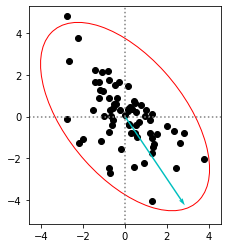

In [129]:
# max in the variance ellipse: 51 deg clockwise (+ve into the trough)
theta = cov_ellipse_plot(ms1, scale=3)

print("Clockwise angle: %.1f" % (180-theta))

### Central Trough

#### bsr12 (deeper level)

Angle (degrees) wrt the zonal direction: 123.64
Pearson corr coeff between x and y: -0.916
Clockwise angle: 56.4


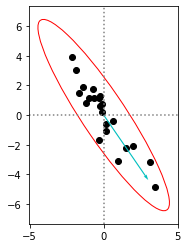

In [115]:
# max in the variance ellipse: 56 deg clockwise (+ve into the trough)
theta = cov_ellipse_plot(bsr12_1, scale=10)

print("Clockwise angle: %.1f" % (180-theta))

#### bsr13

Angle (degrees) wrt the zonal direction: -163.06
Pearson corr coeff between x and y: 0.421
Anti-clockwise angle: 16.9


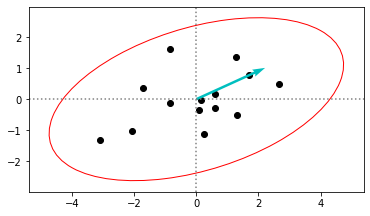

In [112]:
# max in the variance ellipse: 17 deg anti-clockwise (+ve eastward)
theta = cov_ellipse_plot(bsr13a, scale=10)

print("Anti-clockwise angle: %.1f" % (theta-180))

#### istar1

Angle (degrees) wrt the zonal direction: 133.54
Pearson corr coeff between x and y: -0.923
Clockwise angle: 46.5


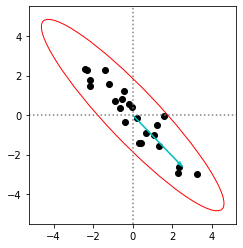

In [114]:
# max in the variance ellipse: 47 deg clockwise (+ve into the trough)
theta = cov_ellipse_plot(istar1, scale=15)

print("Clockwise angle: %.1f" % (180-theta))

#### trough W (deeper level)

Angle (degrees) wrt the zonal direction: 128.18
Pearson corr coeff between x and y: -0.946
Clockwise angle: 51.8


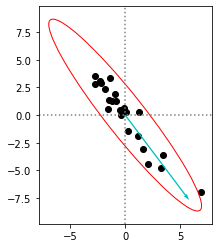

In [113]:
# max in the variance ellipse: 52 deg clockwise (+ve into the trough)
theta = cov_ellipse_plot(troughW1, scale=10)

print("Clockwise angle: %.1f" % (180-theta))